# Precalculated data for layer 20 Places for Half Earth Future (aka Future Places). Includes SPS calculations - February 2023 
In this notebook, we use the biodiversity and contextual data generated in ArcPro to create tables containing precalculated data for the geometries of the layer Future Places. We include global SPS values (stored in species lookup tables) and create SPS values specific to the AOI (SPS_aoi) using biodiversity data for the protected areas of each geometry.
## Setup
### Library import

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import arcgis
from arcgis.gis import GIS
import json
import pandas as pd
from arcgis.features import FeatureLayerCollection
import requests as re
from copy import deepcopy
from itertools import repeat
import functools


### Utils

**getHTfromId**

In [2]:
def getHTfromId(item_id):
    item = gis.content.get(item_id)
    flayer = item.tables[0]
    sdf = flayer.query().sdf
    return sdf

**format_df**

In [ ]:
def format_df(path, file_name, lookups_id):
    df = pd.read_csv(f'{path}/{file_name}')
    col_name = [col for col in df.columns if col in ['SUM_amphib','SUM_birds','SUM_presence','SUM_reptil']]
    df.rename(columns={'SliceNumbe':'SliceNumber',col_name[0]:'SUM'}, inplace=True)
    
    ### Get information from lookup tables:
    lookup = getHTfromId(lookups_id)
    df = df.merge(lookup[['SliceNumber','range_area_km2', 'SPS', 'conservation_target']], how='left',on = 'SliceNumber')
    
    ### Get species area against global species range:
    df['per_global'] = round(df['SUM']/df['range_area_km2']*100,2)
    df.loc[df['per_global']> 100,'per_global'] = 100 ### make max presence 100%
    
    ### Get species area against aoi area (this is currently not needed on the platform):
    # df = df.merge(gadm0[['MOL_ID','AREA_KM2']])
    # df['per_aoi'] = round(df['SUM']/df['AREA_KM2']*100,2)
    # df.loc[df['per_aoi']> 100,'per_aoi'] = 100 ### make max presence 100%
    
    return df

In [3]:
def format_df(path, file_name, lookups_id):
    #save_steps= np.arange(1,217486,step=5000)
    ### Loop over each set of data and add all results to one dictionary that will be a text field in the Feature Service

    df = pd.read_csv(f'{path}/{file_name}')
    col_name = [col for col in df.columns if col in ['amphibians','birds','presence','reptiles']]
    df.rename(columns={'SliceNumbe':'SliceNumber',col_name[0]:'SUM'}, inplace=True)

    ### Get species area against global species range:
    lookup = getHTfromId(lookups_id)
    df = df.merge(lookup[['SliceNumber','range_area_km2']], how='left',on = 'SliceNumber')
    df['per_global'] = round(df['SUM']/df['range_area_km2']*100,2)
    df.loc[df['per_global']> 100,'per_global'] = 100 ### make max presence 100%
    
    ### Get species area against aoi area:
    df = df.merge(places[['MOL_ID','AREA_KM2']])
    df['per_aoi'] = round(df['SUM']/df['AREA_KM2']*100,2)
    df.loc[df['per_aoi']> 100,'per_aoi'] = 100 ### make max presence 100%
    
    return df

### Connect to ArcGIS API

In [4]:
env_path = ".env"
with open(env_path) as f:
   env = {}
   for line in f:
       env_key, _val = line.split("=")
       env_value = _val.split("\n")[0]
       env[env_key] = env_value

In [5]:
aol_password = env['ARCGIS_GRETA_PASS']
aol_username = env['ARCGIS_GRETA_USER']

In [6]:
gis = GIS("https://eowilson.maps.arcgis.com", aol_username, aol_password, profile = "eowilson")

Keyring backend being used (keyring.backends.OS_X.Keyring (priority: 5)) either failed to install or is not recommended by the keyring project (i.e. it is not secure). This means you can not use stored passwords through GIS's persistent profiles. Note that extra system-wide steps must be taken on a Linux machine to use the python keyring module securely. Read more about this at the keyring API doc (http://bit.ly/2EWDP7B) and the ArcGIS API for Python doc (http://bit.ly/2CK2wG8).


The geometries for the up to 20 places for the Half-Earth Future were sent by Scott https://eowilson.maps.arcgis.com/home/item.html?id=358f2419c967453195ec72e4d910fd6e. The precalculations where done in ArcGIS Pro (project `Places_HE_Future`). However, 4 of the 1925 original geometries were removed during the process to extract the biodiversity data because they caused the sample tool to fail in ArcGIS Pro. The removed geometries are clusters (MOL_IDs) 62, 69, 73, 194.

### Import datasets

In [7]:
path_in = '/Users/sofia/Documents/HE_Data/PlacesHE/Inputs'
path_out = '/Users/sofia/Documents/HE_Data/PlacesHE/Outputs'

In [8]:
places= gpd.read_file(f'{path_in}/Geometries/Top_20_places_original/places20.geojson') # Scott's geometry converted to geojson

In [9]:
len(places)

1925

In [10]:
places.head(1)

,OBJECTID,GID_0,NAME_0,cluster,PRmean,AREA_KM2,MOL_ID,Shape_Length,Shape_Area,geometry
0,1,AFG,Afghanistan,1,60.222222,7687.50492,1,442334.303716,1.124109e+10,"POLYGON ((7827944.398 4014125.022, 7829351.252..."


In [11]:
len(places[places['cluster']==places['MOL_ID']])

1925

In [12]:
# Remove the geometries that we couldn't use in ArcGIS Pro
bad_geom = [62, 69, 73, 194]
places = places[~places['MOL_ID'].isin(bad_geom)]
len(places)

1921

In [13]:
# Check if the geometries are valid
sum(places.is_valid) # all geometries are valid

1921

In [26]:
places.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [27]:
places_prj = places.to_crs(epsg=4326)
places_prj.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [28]:
# Save good geometries as geojson. This is the dataset that we are going to use later
places_prj.to_file(f"{path_in}/Geometries/Top_20_places_good_geom/places_good_geometries_20220930.geojson",driver='GeoJSON') 

## Simplification of geometries

In [188]:
# Only simplify (retains all geometries).
!mapshaper-xl 16gb -i /Users/sofia/Documents/HE_Data/PlacesHE/Inputs/Geometries/Top_20_places_good_geom/places_good_geometries_20220930.geojson snap \
    -simplify 20% weighting=0.7 planar keep-shapes \
    -o /Users/sofia/Documents/HE_Data/PlacesHE/Inputs/Geometries/Top_20_places_simplification/places_simplified_20220930.geojson format=geojson precision=0.001 id-field="MOL_ID" force ndjson

Allocating 16 GB of heap memory
[i] Snapped 3 points
[simplify] Repaired 166 intersections; 459 intersections could not be repaired
[o] Wrote /Users/sofia/Documents/HE_Data/PlacesHE/Inputs/Geometries/Top_20_places_simplification/places_simplified_20220930.geojson


In [189]:
sim = gpd.read_file(f'{path_in}/Geometries/Top_20_places_simplification/places_simplified_20220930.geojson') # len 217424, retains all geometries
len(sim)

1921

<AxesSubplot:>

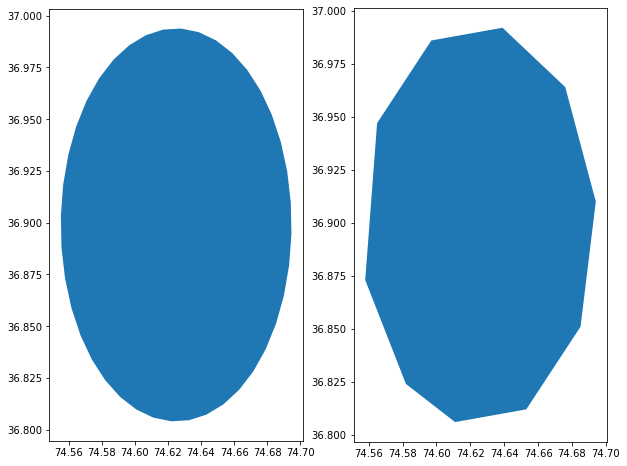

In [190]:
n= 18
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
places_prj[places_prj['cluster']==n].geometry.plot(ax = ax1) 
sim[sim['cluster']==n].geometry.plot(ax = ax2)

## Format Biodiversity data

In [191]:
### Ids of lookup tables for each taxa in ArcGIS online
lookups = {'amphibians':'c221a727e12048b2a6ec8e762bc5f478',
         'birds':'bcb31fd9091446a0af3cfdaed334a8da',
         'mammals':'212a3dd4665845deb5d2adf5b597aae0',
         'reptiles':'5b606a03b3fc431e8d4b9191c88bc2b9'}

# Get data for all taxa
amphibians = format_df(path_in, 'Sample_amph_nozeroes.csv', lookups['amphibians'])
birds = format_df(path_in, 'Sample_birds_nozeroes.csv', lookups['birds'])
mammals = format_df(path_in, 'Sample_mammals_nozeroes.csv', lookups['mammals'])
reptiles = format_df(path_in, 'Sample_reptiles_nozeroes.csv', lookups['reptiles'])


In [192]:
# Format biodiversity data
amphibians = amphibians.groupby('MOL_ID')[['SliceNumber', 'per_global', 'per_aoi']].apply(lambda x: x.to_json(orient='records')).to_frame('amphibians').reset_index()
birds = birds.groupby('MOL_ID')[['SliceNumber', 'per_global', 'per_aoi']].apply(lambda x: x.to_json(orient='records')).to_frame('birds').reset_index()
mammals = mammals.groupby('MOL_ID')[['SliceNumber', 'per_global', 'per_aoi']].apply(lambda x: x.to_json(orient='records')).to_frame('mammals').reset_index()
reptiles = reptiles.groupby('MOL_ID')[['SliceNumber', 'per_global', 'per_aoi']].apply(lambda x: x.to_json(orient='records')).to_frame('reptiles').reset_index()

In [193]:
# Merge biodiversity data
sim = pd.merge(sim, amphibians, how='left', on = 'MOL_ID')
sim = pd.merge(sim, birds, how='left', on = 'MOL_ID')
sim = pd.merge(sim, mammals, how='left', on = 'MOL_ID')
sim = pd.merge(sim, reptiles, how='left', on = 'MOL_ID')
sim.head()

,OBJECTID,GID_0,NAME_0,cluster,PRmean,AREA_KM2,MOL_ID,Shape_Length,Shape_Area,geometry,amphibians,birds,mammals,reptiles
0,1,AFG,Afghanistan,1,60.222222,7687.504920,1,442334.303716,1.124109e+10,"POLYGON ((70.32000 33.89100, 70.38300 33.91000...","[{""SliceNumber"":951.0,""per_global"":4.02,""per_a...","[{""SliceNumber"":26.0,""per_global"":0.02,""per_ao...","[{""SliceNumber"":167.0,""per_global"":0.01,""per_a...","[{""SliceNumber"":9.0,""per_global"":0.29,""per_aoi..."
1,2,AFG,Afghanistan,2,60.222222,4706.088317,2,354254.657577,7.043484e+09,"POLYGON ((70.82700 34.65600, 70.86000 34.63700...","[{""SliceNumber"":951.0,""per_global"":4.19,""per_a...","[{""SliceNumber"":92.0,""per_global"":0.06,""per_ao...","[{""SliceNumber"":167.0,""per_global"":0.12,""per_a...","[{""SliceNumber"":9.0,""per_global"":0.2,""per_aoi""..."
2,3,AFG,Afghanistan,3,52.312500,11768.366965,3,647899.188567,1.746601e+10,"POLYGON ((68.82900 33.74900, 68.87500 33.72900...","[{""SliceNumber"":32.0,""per_global"":100.0,""per_a...","[{""SliceNumber"":26.0,""per_global"":0.04,""per_ao...","[{""SliceNumber"":167.0,""per_global"":1.69,""per_a...","[{""SliceNumber"":1.0,""per_global"":0.63,""per_aoi..."
3,4,AFG,Afghanistan,4,45.500000,205.123344,4,63354.536671,2.958675e+08,"POLYGON ((67.83200 33.44300, 67.86100 33.42600...",NaN,"[{""SliceNumber"":26.0,""per_global"":0.0,""per_aoi...","[{""SliceNumber"":575.0,""per_global"":0.05,""per_a...","[{""SliceNumber"":1.0,""per_global"":0.1,""per_aoi""..."
4,5,AFG,Afghanistan,5,45.500000,205.123344,5,63647.846097,2.979331e+08,"POLYGON ((67.58200 33.74500, 67.61100 33.72800...",NaN,"[{""SliceNumber"":26.0,""per_global"":0.0,""per_aoi...","[{""SliceNumber"":575.0,""per_global"":0.05,""per_a...","[{""SliceNumber"":1.0,""per_global"":0.08,""per_aoi..."


In [194]:
sim.loc[sim['MOL_ID']==1,'amphibians'].values[0]

'[{"SliceNumber":951.0,"per_global":4.02,"per_aoi":53.98},{"SliceNumber":1191.0,"per_global":85.71,"per_aoi":0.08},{"SliceNumber":1707.0,"per_global":0.18,"per_aoi":85.88},{"SliceNumber":1935.0,"per_global":0.12,"per_aoi":52.01},{"SliceNumber":2224.0,"per_global":0.01,"per_aoi":5.97}]'

#### Add nspecies

In [195]:
# Get data for all taxa
amphibians = pd.read_csv('/Users/sofia/Documents/HE_Data/PlacesHE/Inputs/Sample_amph_nozeroes.csv')
birds = pd.read_csv('/Users/sofia/Documents/HE_Data/PlacesHE/Inputs/Sample_birds_nozeroes.csv')
mammals = pd.read_csv('/Users/sofia/Documents/HE_Data/PlacesHE/Inputs/Sample_mammals_nozeroes.csv')
reptiles = pd.read_csv('/Users/sofia/Documents/HE_Data/PlacesHE/Inputs/Sample_reptiles_nozeroes.csv')

In [196]:
amph = amphibians.groupby('MOL_ID')['SliceNumber'].count().astype(int)
bir = birds.groupby('MOL_ID')['SliceNumber'].count().astype(int)
mamm = mammals.groupby('MOL_ID')['SliceNumber'].count().astype(int)
rept = reptiles.groupby('MOL_ID')['SliceNumber'].count().astype(int)

In [197]:
frame = { 'amph_nspecies': amph, 'bird_nspecies': bir, 'mamm_nspecies': mamm, 'rept_nspecies': rept }
df = pd.DataFrame(frame).reset_index()
cols = ['amph_nspecies', 'bird_nspecies', 'mamm_nspecies', 'rept_nspecies']
df[cols] = df[cols].fillna(0)
df[cols] = df[cols].astype('int')
df['nspecies'] = df['amph_nspecies'] + df['bird_nspecies'] + df['mamm_nspecies'] + df['rept_nspecies']
df

,MOL_ID,amph_nspecies,bird_nspecies,mamm_nspecies,rept_nspecies,nspecies
0,1,5,174,65,52,296
1,2,4,192,66,32,294
2,3,2,144,48,33,227
3,4,0,67,27,18,112
4,5,0,62,23,15,100
...,...,...,...,...,...,...
1911,1921,34,364,100,82,580
1912,1922,26,354,89,84,553
1913,1923,34,414,112,89,649
1914,1924,26,326,93,76,521


In [211]:
places_nspecies = sim.merge(df, how='left', on = 'MOL_ID')
places_nspecies.head()

,OBJECTID,GID_0,NAME_0,cluster,PRmean,AREA_KM2,MOL_ID,Shape_Length,Shape_Area,geometry,amphibians,birds,mammals,reptiles,amph_nspecies,bird_nspecies,mamm_nspecies,rept_nspecies,nspecies
0,1,AFG,Afghanistan,1,60.222222,7687.504920,1,442334.303716,1.124109e+10,"POLYGON ((70.32000 33.89100, 70.38300 33.91000...","[{""SliceNumber"":951.0,""per_global"":4.02,""per_a...","[{""SliceNumber"":26.0,""per_global"":0.02,""per_ao...","[{""SliceNumber"":167.0,""per_global"":0.01,""per_a...","[{""SliceNumber"":9.0,""per_global"":0.29,""per_aoi...",5.0,174.0,65.0,52.0,296.0
1,2,AFG,Afghanistan,2,60.222222,4706.088317,2,354254.657577,7.043484e+09,"POLYGON ((70.82700 34.65600, 70.86000 34.63700...","[{""SliceNumber"":951.0,""per_global"":4.19,""per_a...","[{""SliceNumber"":92.0,""per_global"":0.06,""per_ao...","[{""SliceNumber"":167.0,""per_global"":0.12,""per_a...","[{""SliceNumber"":9.0,""per_global"":0.2,""per_aoi""...",4.0,192.0,66.0,32.0,294.0
2,3,AFG,Afghanistan,3,52.312500,11768.366965,3,647899.188567,1.746601e+10,"POLYGON ((68.82900 33.74900, 68.87500 33.72900...","[{""SliceNumber"":32.0,""per_global"":100.0,""per_a...","[{""SliceNumber"":26.0,""per_global"":0.04,""per_ao...","[{""SliceNumber"":167.0,""per_global"":1.69,""per_a...","[{""SliceNumber"":1.0,""per_global"":0.63,""per_aoi...",2.0,144.0,48.0,33.0,227.0
3,4,AFG,Afghanistan,4,45.500000,205.123344,4,63354.536671,2.958675e+08,"POLYGON ((67.83200 33.44300, 67.86100 33.42600...",NaN,"[{""SliceNumber"":26.0,""per_global"":0.0,""per_aoi...","[{""SliceNumber"":575.0,""per_global"":0.05,""per_a...","[{""SliceNumber"":1.0,""per_global"":0.1,""per_aoi""...",0.0,67.0,27.0,18.0,112.0
4,5,AFG,Afghanistan,5,45.500000,205.123344,5,63647.846097,2.979331e+08,"POLYGON ((67.58200 33.74500, 67.61100 33.72800...",NaN,"[{""SliceNumber"":26.0,""per_global"":0.0,""per_aoi...","[{""SliceNumber"":575.0,""per_global"":0.05,""per_a...","[{""SliceNumber"":1.0,""per_global"":0.08,""per_aoi...",0.0,62.0,23.0,15.0,100.0


In [199]:
places_nspecies.to_file(f"{path_out}/places_simpl_precalculated_biodiviversity_20220930.geojson",driver='GeoJSON') 

## Format contextual data

In [212]:
### Read files (Files coming from ArcGIS project Places_HE_Future and expoprted as csv)
### Top 20 places original geometries from Scott: https://eowilson.maps.arcgis.com/home/item.html?id=4848c6b08fac4fa5bff40e9331b6d291

elu= pd.read_csv(f'{path_in}/Places_elu.csv')
le= pd.read_csv(f'{path_in}/Places_encroachment.csv')
pop= pd.read_csv(f'{path_in}/Places_pop.csv')
wp= pd.read_csv(f'{path_in}/wdpa_protection.csv')

cont_lookups={'elu':'83802a7fa3d34c1fa40844fc14683966',
              'landencroach':'b0ad58e2b2404eec811b711b604b9d55'}

In [213]:
# Give layers MOL_ID (wp already has it)
elu = elu.rename(columns ={'OBJECTID_1':'MOL_ID'})
le = le.rename(columns ={'OBJECTID_1':'MOL_ID'})
pop = pop.rename(columns ={'OBJECTID_1':'MOL_ID'})

**Note:** When running the precalculations for the elu layer in ArcGIS Pro, there were some rows that where not processed (for some reason the geometries were not rasterized). Here, we are going to check which geometries were not included in elu table and redo the precalculations in ArcGIS Pro only for those geometries.

#### ELU

In [214]:
l = list(set(places_nspecies.MOL_ID) - set(elu.MOL_ID))
len(l) # number of geometries that have no elu data, repeat analysis in ArcGIS Pro for those

92

In [215]:
# Read new elu table after running the calculations only for the missing geometries
elu2= pd.read_csv(f'{path_in}/Places_elu_nulls.csv')

In [216]:
# Merge both elu datasets
elu = elu.append(elu2)
elu.head(1)

,OID_,MOL_ID,COUNT,AREA,MAJORITY
0,1,1,148821.0,0.750596,184


In [217]:
l = list(set(places_nspecies.MOL_ID) - set(elu.MOL_ID))
len(l) # those geometries don't have elu data

25

There are still 25 geometries that do not have elu data, but this can be because there is no data for those sites

In [ ]:
### Column names needed: 
# 'percent_irrigated', 'percent_rainfed',
#        'percent_rangeland', 'percent_urban', 'population_sum',
#        'majority_land_cover_climate_regime', 'land_cover_majority',
#        'climate_regime_majority',

In [218]:
## Add contextual data: ELU
places_nspecies = places_nspecies.merge(elu[['MOL_ID','MAJORITY']], how='left', on = 'MOL_ID').rename(columns={'MAJORITY':'majority_land_cover_climate_regime'})

In [219]:
places_nspecies.head(1)

,OBJECTID,GID_0,NAME_0,cluster,PRmean,AREA_KM2,MOL_ID,Shape_Length,Shape_Area,geometry,amphibians,birds,mammals,reptiles,amph_nspecies,bird_nspecies,mamm_nspecies,rept_nspecies,nspecies,majority_land_cover_climate_regime
0,1,AFG,Afghanistan,1,60.222222,7687.50492,1,442334.303716,1.124109e+10,"POLYGON ((70.32000 33.89100, 70.38300 33.91000...","[{""SliceNumber"":951.0,""per_global"":4.02,""per_a...","[{""SliceNumber"":26.0,""per_global"":0.02,""per_ao...","[{""SliceNumber"":167.0,""per_global"":0.01,""per_a...","[{""SliceNumber"":9.0,""per_global"":0.29,""per_aoi...",5.0,174.0,65.0,52.0,296.0,184.0


In [220]:
# Retrieve elu lookup table to see to see the correspondences for that elu code
elu_lookup = getHTfromId(cont_lookups['elu'])
elu_lookup.head()

,elu_code,elu,lc_type,lf_type,cr_type,ObjectId
0,301,Sub Tropical Moist Forest on Plains,Forest,Plains,Sub Tropical Moist,1
1,201,Warm Temperate Dry Sparsley or Non vegetated o...,Sparsley or Non vegetated,Plains,Warm Temperate Dry,2
2,151,Cool Temperate Dry Sparsley or Non vegetated o...,Sparsley or Non vegetated,Plains,Cool Temperate Dry,3
3,302,Sub Tropical Moist Cropland on Tablelands,Cropland,Tablelands,Sub Tropical Moist,4
4,152,Cool Temperate Dry Sparsley or Non vegetated o...,Sparsley or Non vegetated,Tablelands,Cool Temperate Dry,5


In [221]:
# Merge in dataset the required info from lookup table
places_nspecies = places_nspecies.merge(elu_lookup[['elu_code','lc_type','cr_type']], how='left', left_on = 'majority_land_cover_climate_regime', right_on = 'elu_code')\
    .drop(columns=['elu_code'])\
    .rename(columns={'lc_type':'land_cover_majority','cr_type':'climate_regime_majority'})

In [222]:
places_nspecies.head(1)

,OBJECTID,GID_0,NAME_0,cluster,PRmean,AREA_KM2,MOL_ID,Shape_Length,Shape_Area,geometry,...,mammals,reptiles,amph_nspecies,bird_nspecies,mamm_nspecies,rept_nspecies,nspecies,majority_land_cover_climate_regime,land_cover_majority,climate_regime_majority
0,1,AFG,Afghanistan,1,60.222222,7687.50492,1,442334.303716,1.124109e+10,"POLYGON ((70.32000 33.89100, 70.38300 33.91000...",...,"[{""SliceNumber"":167.0,""per_global"":0.01,""per_a...","[{""SliceNumber"":9.0,""per_global"":0.29,""per_aoi...",5.0,174.0,65.0,52.0,296.0,184.0,Cropland,Warm Temperate Dry


### Land encroachment

In [223]:
# Each slicenumber with a type of land encroachment
le.head(1)

,OID_,MOL_ID,COUNT,AREA,Variable,Dimensions,SliceNumber,MIN,MAX,RANGE,MEAN,STD,SUM,MEDIAN,PCT90,percentage_land_encroachment
0,1,1,2846.0,0.197635,Variable_new,SliceNumber,1.0,0.276261,0.814483,0.538222,0.462732,0.133903,1316.934454,0.408784,0.684398,26.31


**Note:** The same issue happened with land encroachment, so we need to repeat the analysis in ArcGIS Pro to try to retrieve data for the geometries that were not rasterized

In [224]:
# Check geometries that have no land encroachment data
l = list(set(places_nspecies.MOL_ID) - set(le.MOL_ID))
len(l) # repeat analysis for those

391

In [225]:
# Upload results from second analysis
le2 = pd.read_csv(f'{path_in}/Places_encroachment_nulls.csv')
le2.head(1)

,OID_,MOL_ID,COUNT,AREA,Variable,Dimensions,SliceNumber,MIN,MAX,RANGE,MEAN,STD,SUM,MEDIAN,PCT90,Total,percentage_land_encroachment
0,1,157,250.0,0.017361,Variable_new,SliceNumber,1.0,0.213953,0.86497,0.651016,0.658066,0.121977,164.516578,0.695782,0.750065,1033.0,24.2


In [226]:
le2 = le2.drop(columns={'Total'})
le2.head()

,OID_,MOL_ID,COUNT,AREA,Variable,Dimensions,SliceNumber,MIN,MAX,RANGE,MEAN,STD,SUM,MEDIAN,PCT90,percentage_land_encroachment
0,1,157,250.0,0.017361,Variable_new,SliceNumber,1.0,0.213953,0.864970,0.651016,0.658066,0.121977,164.516578,0.695782,0.750065,24.20
1,2,162,20.0,0.001389,Variable_new,SliceNumber,1.0,0.261984,0.613937,0.351953,0.409149,0.138521,8.182981,0.391272,0.612955,0.93
2,3,223,97.0,0.006736,Variable_new,SliceNumber,1.0,0.190901,0.710594,0.519693,0.415030,0.154798,40.257863,0.380945,0.607992,4.94
3,4,343,1414.0,0.098193,Variable_new,SliceNumber,1.0,0.231417,0.844146,0.612730,0.426742,0.120487,603.412633,0.397267,0.589707,8.95
4,5,344,31.0,0.002153,Variable_new,SliceNumber,1.0,0.357714,0.548353,0.190639,0.431293,0.056941,13.370077,0.421643,0.513450,0.19


In [227]:
# Merge both land encroachment datasets
le = le.append(le2)
le.head(1)

,OID_,MOL_ID,COUNT,AREA,Variable,Dimensions,SliceNumber,MIN,MAX,RANGE,MEAN,STD,SUM,MEDIAN,PCT90,percentage_land_encroachment
0,1,1,2846.0,0.197635,Variable_new,SliceNumber,1.0,0.276261,0.814483,0.538222,0.462732,0.133903,1316.934454,0.408784,0.684398,26.31


In [228]:
# Check geometries that have no land encroachment data
l = list(set(places_nspecies.MOL_ID) - set(le.MOL_ID))
len(l) # those geometries don't have le data

190

In [229]:
# See all land encroachment data for each mol_id
long =le[['SliceNumber','MOL_ID','percentage_land_encroachment']].pivot(index='MOL_ID', columns='SliceNumber', values='percentage_land_encroachment').reset_index().rename(columns=
                                                                                                                              {1.0:'percent_irrigated',
                                                                                                                              2.0:'percent_rainfed',
                                                                                                                              3.0:'percent_rangeland',
                                                                                                                                 4.0:'percent_urban'})

In [230]:
long.head(1)

SliceNumber,MOL_ID,percent_irrigated,percent_rainfed,percent_rangeland,percent_urban
0,1,26.31,57.02,15.5,NaN


In [231]:
# How many encroachment values are higher than 100? 
# This can be due to the way the area is calculated. Small geometries tend to present this issue due to the resolution of the crfs used.
# Anyway, the website will show only the le that is majoritary and the % will stop at 100%
long['sum']=long.iloc[:, 1:5].sum(axis=1)
long[long['sum']>100]

SliceNumber,MOL_ID,percent_irrigated,percent_rainfed,percent_rangeland,percent_urban,sum
2,3,33.07,6.93,111.57,2.66,154.23
5,7,14.04,0.93,101.45,0.14,116.56
19,22,NaN,23.95,108.24,0.74,132.93
20,23,0.67,147.48,43.64,2.01,193.80
24,28,11.90,118.87,26.94,2.91,160.62
...,...,...,...,...,...,...
1637,1825,4.79,12.90,153.44,8.54,179.67
1685,1878,1.22,50.35,106.65,10.75,168.97
1686,1879,20.71,16.55,81.57,3.66,122.49
1702,1895,NaN,NaN,139.54,NaN,139.54


In [233]:
## Add contextual data: Land Encroachment
places_nspecies = places_nspecies.merge(long[['MOL_ID','percent_irrigated', 'percent_rainfed', 'percent_rangeland','percent_urban']],on ='MOL_ID',how='left')

In [235]:
places_nspecies.head(10)

,OBJECTID,GID_0,NAME_0,cluster,PRmean,AREA_KM2,MOL_ID,Shape_Length,Shape_Area,geometry,...,mamm_nspecies,rept_nspecies,nspecies,majority_land_cover_climate_regime,land_cover_majority,climate_regime_majority,percent_irrigated,percent_rainfed,percent_rangeland,percent_urban
0,1,AFG,Afghanistan,1,60.222222,7687.504920,1,442334.303716,1.124109e+10,"POLYGON ((70.32000 33.89100, 70.38300 33.91000...",...,65.0,52.0,296.0,184.0,Cropland,Warm Temperate Dry,26.31,57.02,15.50,NaN
1,2,AFG,Afghanistan,2,60.222222,4706.088317,2,354254.657577,7.043484e+09,"POLYGON ((70.82700 34.65600, 70.86000 34.63700...",...,66.0,32.0,294.0,176.0,Forest,Warm Temperate Moist,1.56,55.09,5.24,NaN
2,3,AFG,Afghanistan,3,52.312500,11768.366965,3,647899.188567,1.746601e+10,"POLYGON ((68.82900 33.74900, 68.87500 33.72900...",...,48.0,33.0,227.0,142.0,Grassland,Cool Temperate Dry,33.07,6.93,111.57,2.66
3,4,AFG,Afghanistan,4,45.500000,205.123344,4,63354.536671,2.958675e+08,"POLYGON ((67.83200 33.44300, 67.86100 33.42600...",...,27.0,18.0,112.0,142.0,Grassland,Cool Temperate Dry,0.88,NaN,1.77,NaN
4,5,AFG,Afghanistan,5,45.500000,205.123344,5,63647.846097,2.979331e+08,"POLYGON ((67.58200 33.74500, 67.61100 33.72800...",...,23.0,15.0,100.0,142.0,Grassland,Cool Temperate Dry,NaN,NaN,2.64,NaN
5,6,AFG,Afghanistan,6,45.000000,205.123344,6,60084.865949,2.726637e+08,"POLYGON ((66.08200 29.60700, 66.11100 29.59000...",...,35.0,43.0,157.0,273.0,Sparsley or Non vegetated,Sub Tropical Dry,NaN,NaN,NaN,NaN
6,7,AFG,Afghanistan,7,43.538462,9262.838696,7,449212.586279,1.268476e+10,"POLYGON ((65.82000 30.91200, 65.87000 30.93100...",...,36.0,44.0,179.0,283.0,Sparsley or Non vegetated,Sub Tropical Dry,14.04,0.93,101.45,0.14
7,8,AFG,Afghanistan,8,42.000000,3949.445557,8,272991.094787,5.269999e+09,"POLYGON ((65.31900 29.76600, 65.40100 29.85000...",...,36.0,39.0,153.0,283.0,Sparsley or Non vegetated,Sub Tropical Dry,NaN,NaN,34.82,NaN
8,9,AFG,Afghanistan,9,42.000000,205.123344,9,60084.865956,2.726637e+08,"POLYGON ((65.58200 29.60700, 65.61100 29.59000...",...,28.0,35.0,106.0,283.0,Sparsley or Non vegetated,Sub Tropical Dry,NaN,NaN,1.14,NaN
9,10,AFG,Afghanistan,10,42.000000,205.123344,10,61232.826283,2.808491e+08,"POLYGON ((66.58200 31.06400, 66.61100 31.04700...",...,32.0,30.0,153.0,186.0,Grassland,Warm Temperate Dry,0.19,0.50,1.87,NaN


### Population

In [236]:
# Population table, we need the SUM attribute
pop.head(1)

,OID_,MOL_ID,COUNT,AREA,SUM
0,1,1,10824.0,0.751667,2.092001e+06


In [237]:
## Add contextual data: POP
places_nspecies = places_nspecies.merge(pop[['MOL_ID','SUM']],on ='MOL_ID',how='left')
places_nspecies.head(1)

,OBJECTID,GID_0,NAME_0,cluster,PRmean,AREA_KM2,MOL_ID,Shape_Length,Shape_Area,geometry,...,rept_nspecies,nspecies,majority_land_cover_climate_regime,land_cover_majority,climate_regime_majority,percent_irrigated,percent_rainfed,percent_rangeland,percent_urban,SUM
0,1,AFG,Afghanistan,1,60.222222,7687.50492,1,442334.303716,1.124109e+10,"POLYGON ((70.32000 33.89100, 70.38300 33.91000...",...,52.0,296.0,184.0,Cropland,Warm Temperate Dry,26.31,57.02,15.5,NaN,2.092001e+06


In [238]:
places_nspecies = places_nspecies.rename(columns ={'SUM':'population_sum'})
places_nspecies.head(1)

,OBJECTID,GID_0,NAME_0,cluster,PRmean,AREA_KM2,MOL_ID,Shape_Length,Shape_Area,geometry,...,rept_nspecies,nspecies,majority_land_cover_climate_regime,land_cover_majority,climate_regime_majority,percent_irrigated,percent_rainfed,percent_rangeland,percent_urban,population_sum
0,1,AFG,Afghanistan,1,60.222222,7687.50492,1,442334.303716,1.124109e+10,"POLYGON ((70.32000 33.89100, 70.38300 33.91000...",...,52.0,296.0,184.0,Cropland,Warm Temperate Dry,26.31,57.02,15.5,NaN,2.092001e+06


#### Protection

In [239]:
wp.head()

,OID_,MOL_ID,COUNT,AREA,Variable,Dimensions,SliceNumber,SUM,percentage_protected
0,1,2,19.0,19000000.0,WDPA_GDAL3_1_0_20210615_FILTERED_TERR01_missin...,SliceNumber,1.0,1013.981747,0.13
1,2,3,8.0,8000000.0,WDPA_GDAL3_1_0_20210615_FILTERED_TERR01_missin...,SliceNumber,1.0,232.988981,0.03
2,3,4,68.0,68000000.0,WDPA_GDAL3_1_0_20210615_FILTERED_TERR01_missin...,SliceNumber,1.0,5466.303537,0.71
3,4,14,490.0,490000000.0,WDPA_GDAL3_1_0_20210615_FILTERED_TERR01_missin...,SliceNumber,1.0,40076.577079,5.21
4,5,18,124.0,124000000.0,WDPA_GDAL3_1_0_20210615_FILTERED_TERR01_missin...,SliceNumber,1.0,11443.240224,1.49


In [240]:
## Add contextual data: POP
places_nspecies = places_nspecies.merge(wp[['MOL_ID','percentage_protected']],on ='MOL_ID',how='left')
places_nspecies.head(1)

,OBJECTID,GID_0,NAME_0,cluster,PRmean,AREA_KM2,MOL_ID,Shape_Length,Shape_Area,geometry,...,nspecies,majority_land_cover_climate_regime,land_cover_majority,climate_regime_majority,percent_irrigated,percent_rainfed,percent_rangeland,percent_urban,population_sum,percentage_protected
0,1,AFG,Afghanistan,1,60.222222,7687.50492,1,442334.303716,1.124109e+10,"POLYGON ((70.32000 33.89100, 70.38300 33.91000...",...,296.0,184.0,Cropland,Warm Temperate Dry,26.31,57.02,15.5,NaN,2.092001e+06,NaN


In [241]:
places_nspecies.head(10)

,OBJECTID,GID_0,NAME_0,cluster,PRmean,AREA_KM2,MOL_ID,Shape_Length,Shape_Area,geometry,...,nspecies,majority_land_cover_climate_regime,land_cover_majority,climate_regime_majority,percent_irrigated,percent_rainfed,percent_rangeland,percent_urban,population_sum,percentage_protected
0,1,AFG,Afghanistan,1,60.222222,7687.504920,1,442334.303716,1.124109e+10,"POLYGON ((70.32000 33.89100, 70.38300 33.91000...",...,296.0,184.0,Cropland,Warm Temperate Dry,26.31,57.02,15.50,NaN,2.092001e+06,NaN
1,2,AFG,Afghanistan,2,60.222222,4706.088317,2,354254.657577,7.043484e+09,"POLYGON ((70.82700 34.65600, 70.86000 34.63700...",...,294.0,176.0,Forest,Warm Temperate Moist,1.56,55.09,5.24,NaN,6.288113e+05,0.13
2,3,AFG,Afghanistan,3,52.312500,11768.366965,3,647899.188567,1.746601e+10,"POLYGON ((68.82900 33.74900, 68.87500 33.72900...",...,227.0,142.0,Grassland,Cool Temperate Dry,33.07,6.93,111.57,2.66,6.122301e+06,0.03
3,4,AFG,Afghanistan,4,45.500000,205.123344,4,63354.536671,2.958675e+08,"POLYGON ((67.83200 33.44300, 67.86100 33.42600...",...,112.0,142.0,Grassland,Cool Temperate Dry,0.88,NaN,1.77,NaN,3.773772e+03,0.71
4,5,AFG,Afghanistan,5,45.500000,205.123344,5,63647.846097,2.979331e+08,"POLYGON ((67.58200 33.74500, 67.61100 33.72800...",...,100.0,142.0,Grassland,Cool Temperate Dry,NaN,NaN,2.64,NaN,1.882826e+03,NaN
5,6,AFG,Afghanistan,6,45.000000,205.123344,6,60084.865949,2.726637e+08,"POLYGON ((66.08200 29.60700, 66.11100 29.59000...",...,157.0,273.0,Sparsley or Non vegetated,Sub Tropical Dry,NaN,NaN,NaN,NaN,6.723271e+03,NaN
6,7,AFG,Afghanistan,7,43.538462,9262.838696,7,449212.586279,1.268476e+10,"POLYGON ((65.82000 30.91200, 65.87000 30.93100...",...,179.0,283.0,Sparsley or Non vegetated,Sub Tropical Dry,14.04,0.93,101.45,0.14,4.315277e+05,NaN
7,8,AFG,Afghanistan,8,42.000000,3949.445557,8,272991.094787,5.269999e+09,"POLYGON ((65.31900 29.76600, 65.40100 29.85000...",...,153.0,283.0,Sparsley or Non vegetated,Sub Tropical Dry,NaN,NaN,34.82,NaN,4.230695e+03,NaN
8,9,AFG,Afghanistan,9,42.000000,205.123344,9,60084.865956,2.726637e+08,"POLYGON ((65.58200 29.60700, 65.61100 29.59000...",...,106.0,283.0,Sparsley or Non vegetated,Sub Tropical Dry,NaN,NaN,1.14,NaN,9.582674e+02,NaN
9,10,AFG,Afghanistan,10,42.000000,205.123344,10,61232.826283,2.808491e+08,"POLYGON ((66.58200 31.06400, 66.61100 31.04700...",...,153.0,186.0,Grassland,Warm Temperate Dry,0.19,0.50,1.87,NaN,1.314997e+04,NaN


In [242]:
places_nspecies = places_nspecies.fillna(0)

In [243]:
places_nspecies.loc[places_nspecies['MOL_ID']==20,'mammals'].values[0] # check the string to see it's formatted correctly 

'[{"SliceNumber":575.0,"per_global":0.19,"per_aoi":87.54},{"SliceNumber":605.0,"per_global":0.0,"per_aoi":77.68},{"SliceNumber":607.0,"per_global":0.01,"per_aoi":86.61},{"SliceNumber":609.0,"per_global":0.0,"per_aoi":94.73},{"SliceNumber":615.0,"per_global":0.04,"per_aoi":67.36},{"SliceNumber":635.0,"per_global":0.0,"per_aoi":90.78},{"SliceNumber":1176.0,"per_global":0.09,"per_aoi":44.75},{"SliceNumber":1613.0,"per_global":0.05,"per_aoi":11.83},{"SliceNumber":1784.0,"per_global":0.0,"per_aoi":0.12},{"SliceNumber":1787.0,"per_global":0.0,"per_aoi":95.77},{"SliceNumber":1955.0,"per_global":0.01,"per_aoi":65.97},{"SliceNumber":2106.0,"per_global":0.01,"per_aoi":94.73},{"SliceNumber":2240.0,"per_global":0.01,"per_aoi":81.62},{"SliceNumber":2335.0,"per_global":0.01,"per_aoi":42.9},{"SliceNumber":2341.0,"per_global":0.0,"per_aoi":0.12},{"SliceNumber":2811.0,"per_global":0.17,"per_aoi":69.22},{"SliceNumber":2889.0,"per_global":0.0,"per_aoi":97.86},{"SliceNumber":2927.0,"per_global":0.04,"per_

In [244]:
places_nspecies.columns

Index(['OBJECTID', 'GID_0', 'NAME_0', 'cluster', 'PRmean', 'AREA_KM2',
       'MOL_ID', 'Shape_Length', 'Shape_Area', 'geometry', 'amphibians',
       'birds', 'mammals', 'reptiles', 'amph_nspecies', 'bird_nspecies',
       'mamm_nspecies', 'rept_nspecies', 'nspecies',
       'majority_land_cover_climate_regime', 'land_cover_majority',
       'climate_regime_majority', 'percent_irrigated', 'percent_rainfed',
       'percent_rangeland', 'percent_urban', 'population_sum',
       'percentage_protected'],
      dtype='object')

In [245]:
places_nspecies[places_nspecies['MOL_ID']!=places_nspecies['cluster']]

,OBJECTID,GID_0,NAME_0,cluster,PRmean,AREA_KM2,MOL_ID,Shape_Length,Shape_Area,geometry,...,nspecies,majority_land_cover_climate_regime,land_cover_majority,climate_regime_majority,percent_irrigated,percent_rainfed,percent_rangeland,percent_urban,population_sum,percentage_protected


In [246]:
places_nspecies.to_file(f"{path_out}/top_places_precalculated_nspecies.geojson",driver='GeoJSON')


In [247]:
a = gpd.read_file(f"{path_out}/top_places_precalculated_nspecies.geojson")

In [248]:
b= gpd.read_file(f"{path_out}/top_places_precalculated_nspecies_backup_20220930.geojson")

In [254]:
a.columns

Index(['OBJECTID', 'GID_0', 'NAME_0', 'cluster', 'PRmean', 'AREA_KM2',
       'MOL_ID', 'Shape_Length', 'Shape_Area', 'amphibians', 'birds',
       'mammals', 'reptiles', 'amph_nspecies', 'bird_nspecies',
       'mamm_nspecies', 'rept_nspecies', 'nspecies',
       'majority_land_cover_climate_regime', 'land_cover_majority',
       'climate_regime_majority', 'percent_irrigated', 'percent_rainfed',
       'percent_rangeland', 'percent_urban', 'population_sum',
       'percentage_protected', 'geometry'],
      dtype='object')